### I. Download data of SaaS firms from AlphaVantage

#### 1. Test download and check an example stock

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set the global display format for numbers with commas
pd.options.display.float_format = '{:,.0f}'.format

In [4]:
# API Key to access data fron alpha vantage
Eliza_API_key = 'ELIZA-BUI'
example_ticker = 'SNOW'

# get url link & request access
url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={example_ticker}&apikey={Eliza_API_key}'
r = requests.get(url)
data = r.json()

In [5]:
#preview data to understand structure
#data

In [6]:
# Check data's keys
data.keys()

dict_keys(['symbol', 'annualReports', 'quarterlyReports'])

In [7]:
# Check Annual Report
annual_df = pd.DataFrame(data['annualReports'])
annual_df

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
0,2023-01-31,USD,1348119000,2078441000,2216113000,717540000,-842267000,1402328000,788058000,2190386000,...,24700000,96245000,-815172000,-18467000,None,-797526000,-819512000,-842267000,-746022000,-796705000
1,2022-01-31,USD,760894000,1232049000,1513107000,458433000,-715036000,1008998000,466932000,1475930000,...,13700000,45676000,-676960000,2988000,None,-679948000,-696673000,-715036000,-669360000,-679948000
2,2021-01-31,USD,349461000,604828000,900840000,242588000,-543937000,655452000,237946000,893398000,...,7000000,2800000,-537040000,2062000,None,-539102000,-538879000,-543937000,-541137000,-539102000


In [8]:
# Check Quarterly Report
quarterly_df = pd.DataFrame(data['quarterlyReports'])
quarterly_df.head()

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
0,2023-10-31,USD,505225000,737073000,685231000,228948000,-260623000,433783000,332065000,765848000,...,10000000,22500000,-210859000,3392000,None,-214694000,-209215000,-260623000,-238123000,-214251000
1,2023-07-31,USD,455626000,677118000,666229000,218392000,-285407000,427037000,313996000,741033000,...,8500000,20800000,-230588000,-3721000,None,-227320000,-228736000,-285407000,-264607000,-226867000
2,2023-04-30,USD,414185000,626699000,652697000,209414000,-273238000,410011000,277412000,687423000,...,7600000,33272000,-232232000,-6605000,None,-226064000,-218620000,-273238000,-239966000,-225627000
3,2023-01-31,USD,383355000,592094000,614657000,205657000,-239750000,380980000,242125000,623105000,...,7600000,28020000,-206797000,372000,None,-207484000,-177083000,-239750000,-211730000,-207169000
4,2022-10-31,USD,366307000,560028000,562760000,190721000,-206019000,360939000,211387000,572326000,...,6600000,11100000,-196927000,4009000,None,-201442000,-222258000,-206019000,-194919000,-200936000


In [9]:
quarterly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   fiscalDateEnding                   17 non-null     object
 1   reportedCurrency                   17 non-null     object
 2   grossProfit                        17 non-null     object
 3   totalRevenue                       17 non-null     object
 4   costOfRevenue                      17 non-null     object
 5   costofGoodsAndServicesSold         17 non-null     object
 6   operatingIncome                    17 non-null     object
 7   sellingGeneralAndAdministrative    17 non-null     object
 8   researchAndDevelopment             17 non-null     object
 9   operatingExpenses                  17 non-null     object
 10  investmentIncomeNet                17 non-null     object
 11  netInterestIncome                  17 non-null     object
 12  interestIn

**Notes:** 
- Annual report stops at the last time a full year's result is reported, which can be delayed by up to 12 months, as in the case of SNOW here. At the time of this analysis, Jan 2024, the last annual data available is from Jan 2023. 
- In addition, some companies are new IPOs, making full-year historical data limited
- Thus, I will use Quarterly reports in this analysis to get more and most updated data points from quarterly filings


**For all in tents and purposes, Annual Revenue is calculated by summing the last twelve month/last four quarterly reported revenue. So is EBITDA. That way, all metrics used in this analysis are still annual metrics, but based on latest rolling 4 quarters**

#### 2. Scrape AlphaVantage for financial data from a list of tickers

In [10]:
# Function to fetch financial data from Alpha Vantage for a list of tickers and store it in a DataFrame
def fetch_quarterly_financial_data(ticker_list, api_key, function='INCOME_STATEMENT'):
    
    # empty dictionary to save data
    consolidated_quarterly_dict = {}
    
    for ticker in ticker_list:
        try:
            # Construct the URL for the Alpha Vantage API request
            url = f'https://www.alphavantage.co/query?function={function}&symbol={ticker}&apikey={api_key}'
            
            # Make the API request
            response = requests.get(url)
            
            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                data = response.json()
                
                # Extract the relevant financial data from the API response
                if 'quarterlyReports' in data.keys():
                    # put data in dataframe
                    quarterly_df = pd.DataFrame(data['quarterlyReports'])
                    
                    # Store the quarterly data in the dictionary with the ticker symbol as the key
                    consolidated_quarterly_dict[ticker] = quarterly_df
                
                else:
                    print(f"No quarterly data found for {ticker}.")
                    
            else:
                print(f"Failed to fetch data for {ticker}. Status code: {response.status_code}")
        
        except Exception as e:
            print(f"Error fetching data for {ticker}: {str(e)}")
            
    # return dictionary
    return consolidated_quarterly_dict

In [11]:
# Declare list of ticker
SaaS_tickers = ["ADBE", "CRM", "BASE", "FICO", "MDB", "TEAM", "ASAN", "DDOG", "SNOW", "ZS", "CRWD", "DASH", 
                "ADP", "CYBR", "DOCU"]

# Fetch financial data for the SaaS tickers
consolidated_quarterly_dict = fetch_quarterly_financial_data(SaaS_tickers, Eliza_API_key)

In [12]:
# Preview consolidated dataframe
display(consolidated_quarterly_dict.keys())
display(len(consolidated_quarterly_dict.keys()))

dict_keys(['ADBE', 'CRM', 'BASE', 'FICO', 'MDB', 'TEAM', 'ASAN', 'DDOG', 'SNOW', 'ZS', 'CRWD', 'DASH', 'ADP', 'CYBR', 'DOCU'])

15

### II. Process data to see which one satisfies Rule of 40 and Rule of 50

In [13]:
# Copy extracted data to a new dictionary to perform data manipulation without the need to recall API
con_quarterly_dict = consolidated_quarterly_dict

In [14]:
# Function to convert all columns in a dataframe except some from exclusion list
def convert_columns_to_float_except(df, columns_to_exclude):
    # Create a dictionary to specify data types for each column
    data_types = {column: 'float' for column in df.columns if column not in columns_to_exclude}

    # Replace 'None' with 'NaN' in all columns using map
    df = df.apply(lambda col: col.map(lambda x: np.nan if x == 'None' else x))

    # Convert columns to 'float' using the astype method
    df = df.astype(data_types)
    
    return df

In [15]:
# Iterate through the dictionary and apply the function to each DataFrame
for ticker, quarterly_df in con_quarterly_dict.items():
    
    # Convert fiscal date ending to datetime
    quarterly_df['fiscalDateEnding'] = pd.to_datetime(quarterly_df['fiscalDateEnding'])

    # List of columns to exclude
    excluded_columns = ['fiscalDateEnding', 'reportedCurrency']
    
    # Run function to convert all columns to float type except those specified to be excluded above
    quarterly_df = convert_columns_to_float_except(quarterly_df, excluded_columns)

    # Add EBITDA Margin
    quarterly_df['EBITDA Margin %'] = quarterly_df['ebitda']/quarterly_df['totalRevenue'] * 100

    # Add Calendar Year col
    quarterly_df['Calendar Year'] = quarterly_df['fiscalDateEnding'].dt.year

    # Add Quarter col
    quarterly_df['Calendar Quarter'] = quarterly_df['fiscalDateEnding'].dt.quarter
   
    # Sort the DataFrame by 'fiscalDateEnding' in ascending order if it's not already sorted.
    quarterly_df.sort_values(by='fiscalDateEnding', inplace=True)

    # Calculate the sum of the last 4 quarters' revenue using rolling and sum
    quarterly_df['Last 4Q Revenue'] = quarterly_df['totalRevenue'].rolling(window=4).sum()
    
    # Convert to (mil) unit
    quarterly_df['Last 4Q Revenue (mil)'] = quarterly_df['Last 4Q Revenue'] / (10**6)
      
    # Calculate the sum of the last 4 quarters' EBITDA using rolling and sum
    quarterly_df['Last 4Q EBITDA'] = quarterly_df['ebitda'].rolling(window=4).sum()
    
    # Convert to (mil) unit
    quarterly_df['Last 4Q EBITDA (mil)'] = quarterly_df['Last 4Q EBITDA'] / (10**6)

    # Calculate the YoY revenue growth with a lag of 4 quarters
    quarterly_df['YoY Rolling 4Q Revenue Growth'] = quarterly_df['Last 4Q Revenue'].pct_change(periods=4) * 100
    
    # Calculate LTM/ last 4Q EBITDA Margin using Last 4Q EBITDA/Revenue
    quarterly_df['Rolling 4Q EBITDA Margin %'] = quarterly_df['Last 4Q EBITDA']/quarterly_df['Last 4Q Revenue'] * 100

    # Calculate YoY revenue growth and EBITDA margin SUM
    quarterly_df['YoY Rev Growth + EBITDA Margin'] = (quarterly_df['YoY Rolling 4Q Revenue Growth'] + 
                                                                    quarterly_df['Rolling 4Q EBITDA Margin %'])
    
    # Calculate if metrics pass Rule of 40 and Rule of 50
    quarterly_df['Rule40_Pass'] = quarterly_df['YoY Rev Growth + EBITDA Margin'].apply(lambda x: True if x >= 40 else False)
    quarterly_df['Rule50_Pass'] = quarterly_df['YoY Rev Growth + EBITDA Margin'].apply(lambda x: True if x >= 50 else False)
   
    # Assign the modified quarterly_df back to the dictionary using the same key
    con_quarterly_dict[ticker] = quarterly_df

In [16]:
# preview a sample ticker
con_quarterly_dict['SNOW']

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,Calendar Quarter,Last 4Q Revenue,Last 4Q Revenue (mil),Last 4Q EBITDA,Last 4Q EBITDA (mil),YoY Rolling 4Q Revenue Growth,Rolling 4Q EBITDA Margin %,YoY Rev Growth + EBITDA Margin,Rule40_Pass,Rule50_Pass
16,2019-10-31,USD,"43,523,000","73,012,000","29,489,000","29,489,000","-90,132,000","30,318,000","27,669,000","133,655,000",...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
15,2020-01-31,USD,"53,170,000","87,692,000","34,522,000","34,522,000","-85,112,000","28,129,000","29,709,000","138,282,000",...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
14,2020-04-30,USD,"66,258,000","108,815,000","42,557,000","42,557,000","-96,403,000","31,506,000","33,278,000","162,661,000",...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
13,2020-07-31,USD,"82,699,000","133,145,000","50,446,000","50,446,000","-77,683,000","31,186,000","36,533,000","160,382,000",...,3,"402,664,000",403,"-343,410,000",-343,NaN,-85,NaN,False,False
12,2020-10-31,USD,"92,943,000","162,824,000","255,840,000","66,681,000","-169,454,000","188,259,000","74,138,000","262,397,000",...,4,"492,476,000",492,"-422,725,000",-423,NaN,-86,NaN,False,False
11,2021-01-31,USD,"107,561,000","193,644,000","297,765,000","82,904,000","-200,397,000","213,961,000","93,997,000","307,958,000",...,1,"598,428,000",598,"-538,375,000",-538,NaN,-90,NaN,False,False
10,2021-04-30,USD,"131,568,000","232,114,000","334,829,000","97,346,000","-205,595,000","227,367,000","109,796,000","337,163,000",...,2,"721,727,000",722,"-638,973,000",-639,NaN,-89,NaN,False,False
9,2021-07-31,USD,"166,077,000","275,398,000","356,152,000","106,121,000","-200,141,000","248,131,000","118,087,000","366,218,000",...,3,"863,980,000",864,"-761,771,000",-762,115,-88,26,False,False
8,2021-10-31,USD,"213,655,000","337,841,000","377,712,000","120,786,000","-157,271,000","255,026,000","115,900,000","370,926,000",...,4,"1,038,997,000","1,039","-748,588,000",-749,111,-72,39,False,False
7,2022-01-31,USD,"249,594,000","386,696,000","425,806,000","134,180,000","-152,029,000","278,474,000","123,149,000","401,623,000",...,1,"1,232,049,000","1,232","-687,968,000",-688,106,-56,50,True,True


### III. Analytical Summary & Visualization: Focus on 2020-2023 period

In [17]:
# Convert the dictionary values into a single DataFrame
full_df = pd.concat(con_quarterly_dict.values(), keys=con_quarterly_dict.keys())

# Reset the index for a cleaner DataFrame
full_df.reset_index(level=0, inplace=True)
full_df.rename(columns={'level_0': 'Ticker'}, inplace=True)

# Display the resulting DataFrame
#display(full_df.info())

# List columns of interest
selected_columns = ['Ticker','fiscalDateEnding', 'Calendar Year', 'Calendar Quarter', 'Last 4Q Revenue (mil)', 
                    'Last 4Q EBITDA (mil)', 'YoY Rolling 4Q Revenue Growth', 'Rolling 4Q EBITDA Margin %', 
                    'YoY Rev Growth + EBITDA Margin', 'Rule40_Pass', 'Rule50_Pass']

# Extracted only related data for stocks in period 2020-2023
focused_df = full_df[full_df['Calendar Year'] >= 2020][selected_columns]

# Display the resulting DataFrame
display(focused_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, 15 to 0
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Ticker                          227 non-null    object        
 1   fiscalDateEnding                227 non-null    datetime64[ns]
 2   Calendar Year                   227 non-null    int32         
 3   Calendar Quarter                227 non-null    int32         
 4   Last 4Q Revenue (mil)           214 non-null    float64       
 5   Last 4Q EBITDA (mil)            214 non-null    float64       
 6   YoY Rolling 4Q Revenue Growth   193 non-null    float64       
 7   Rolling 4Q EBITDA Margin %      214 non-null    float64       
 8   YoY Rev Growth + EBITDA Margin  193 non-null    float64       
 9   Rule40_Pass                     227 non-null    bool          
 10  Rule50_Pass                     227 non-null    bool          
dtypes: bool(2), 

None

In [18]:
# Check for infinite values in 'YoY Rev Growth + EBITDA Margin' column
is_inf = np.isinf(focused_df['YoY Rev Growth + EBITDA Margin'])

# Replace infinite values with NaN
focused_df.loc[is_inf, 'YoY Rev Growth + EBITDA Margin'] = np.nan

# Check for infinite values in 'YoY Rev Growth + EBITDA Margin' column
print(focused_df[is_inf])

Empty DataFrame
Columns: [Ticker, fiscalDateEnding, Calendar Year, Calendar Quarter, Last 4Q Revenue (mil), Last 4Q EBITDA (mil), YoY Rolling 4Q Revenue Growth, Rolling 4Q EBITDA Margin %, YoY Rev Growth + EBITDA Margin, Rule40_Pass, Rule50_Pass]
Index: []


#### Q1: How often each stock achieves Rule of 40 vs Rule of 50 within 4 years period from 2020 to 2023?

In [19]:
# Name year of interest
latest_year = 2023

# Group by 'Ticker' and calculate the sum of 'Rule40_Pass' and 'Rule50_Pass' for each group
pass_counts = focused_df.groupby('Ticker')[['Rule40_Pass', 'Rule50_Pass']].sum().reset_index()

# Rename columns for clarity
pass_counts.rename(columns={'Rule40_Pass': 'Count_Rule40_Pass', 'Rule50_Pass': 'Count_Rule50_Pass'}, inplace=True)

# Filter the DataFrame for the year 2023
data_latest_year = focused_df[focused_df['Calendar Year'] == latest_year]

# Find the latest fiscalDateEnding for each ticker in 2023
latest_dates = data_latest_year.groupby('Ticker')['fiscalDateEnding'].max().reset_index()

# Merge the latest_dates DataFrame with data_latest_year to get the corresponding 'YoY Rev Growth + EBITDA Margin' values
latest_values_latest_year = latest_dates.merge(data_latest_year, on=['Ticker', 'fiscalDateEnding'], how='left')

# Rename columns
latest_values_latest_year.rename(columns={'fiscalDateEnding': 'Last Filing fiscalDateEnding'}, inplace=True)

# Merge the pass_counts DataFrame with the calculated averages
pass_counts = pass_counts.merge(latest_values_latest_year[['Ticker', 'Last Filing fiscalDateEnding', 
                                                           'Last 4Q Revenue (mil)', 'Last 4Q EBITDA (mil)', 
                                                           'YoY Rolling 4Q Revenue Growth',
                                                           'Rolling 4Q EBITDA Margin %', 
                                                           'YoY Rev Growth + EBITDA Margin']],
                                                           on=['Ticker'], how='left')

display(pass_counts)

,Ticker,Count_Rule40_Pass,Count_Rule50_Pass,Last Filing fiscalDateEnding,Last 4Q Revenue (mil),Last 4Q EBITDA (mil),YoY Rolling 4Q Revenue Growth,Rolling 4Q EBITDA Margin %,YoY Rev Growth + EBITDA Margin
0,ADBE,16,12,2023-12-01,"19,409","7,756",10,40,50
1,ADP,0,0,2023-09-30,"18,268","5,367",8,29,38
2,ASAN,0,0,2023-10-31,628,-267,24,-43,-18
3,BASE,0,0,2023-10-31,172,-72,16,-42,-26
4,CRM,9,5,2023-10-31,"33,714","7,784",11,23,34
5,CRWD,16,14,2023-10-31,"2,967",55,46,2,48
6,CYBR,0,0,2023-09-30,698,-127,22,-18,3
7,DASH,1,1,2023-09-30,"8,153",-989,35,-12,22
8,DDOG,12,12,2023-09-30,"2,000",27,32,1,34
9,DOCU,5,1,2023-10-31,"2,702",200,11,7,19


**Observations**

- ADBE and CRWD are the clear leaders with all quarters achieving Rule of 40 and 12 and 14 quarters achieving Rule of 50 (respectively)
- DDOG takes second place with 12 quarters achieving Rule of 40 and Rule of 50
- CRM, FICO, SNOW, DOCU had some good performing quarters in the past
- Other stocks didn't make it to the high-performance clubs

**Let's visualize this data table**

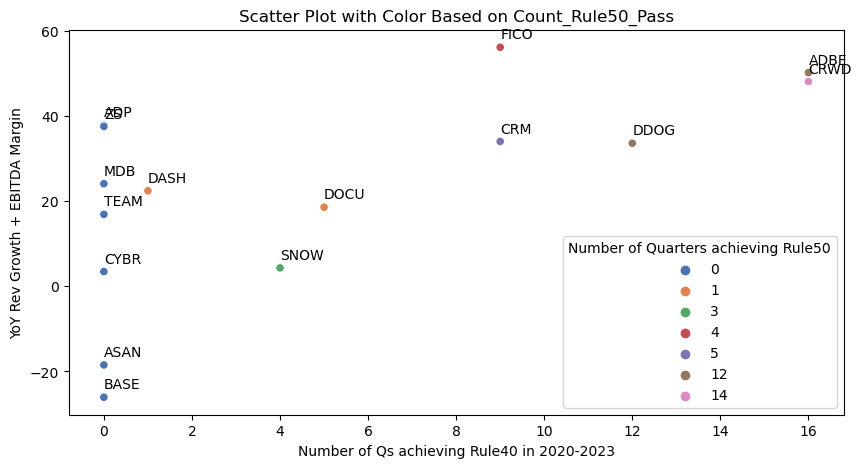

In [20]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 5))
scatter = sns.scatterplot(data=pass_counts, x="Count_Rule40_Pass", y="YoY Rev Growth + EBITDA Margin",
                          hue="Count_Rule50_Pass", 
                          palette="deep", 
                          #style="Count_Rule50_Pass",
                          #size ="Count_Rule50_Pass", 
                          )

plt.xlabel('Number of Qs achieving Rule40 in 2020-2023')
plt.ylabel('YoY Rev Growth + EBITDA Margin')
plt.title('Scatter Plot with Color Based on Count_Rule50_Pass')

# Move the legend to the upper right corner
scatter.legend(title='Number of Quarters achieving Rule50', loc='lower right')

# Add ticker names to the data points
for i, row in pass_counts.iterrows():
    plt.annotate(row['Ticker'], (row['Count_Rule40_Pass'], row['YoY Rev Growth + EBITDA Margin'] + 2))

plt.show()

#### Q2: Charting Revenue Growth vs EBITDA Margin and Rule of 40

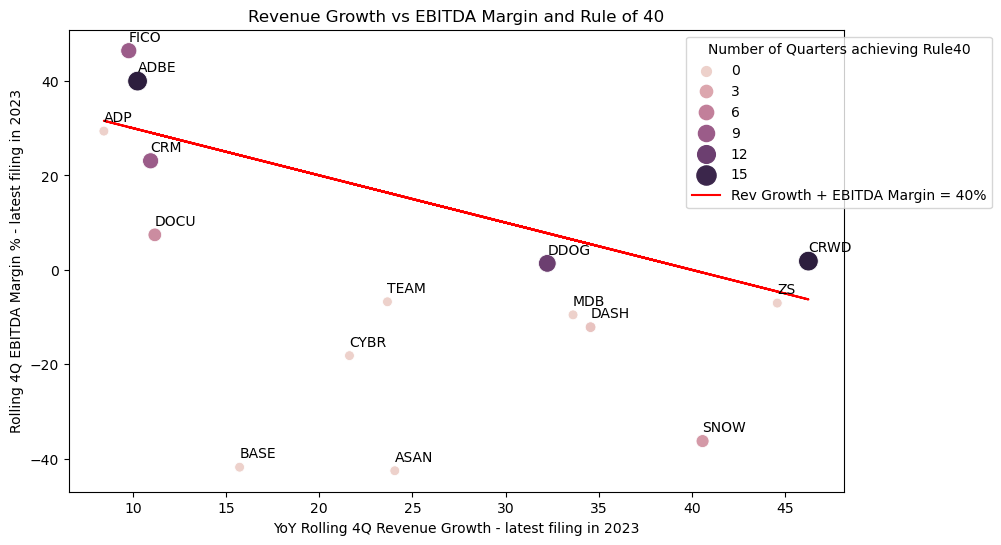

In [21]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=pass_counts, x="YoY Rolling 4Q Revenue Growth", y="Rolling 4Q EBITDA Margin %",
                          hue = "Count_Rule40_Pass", 
                          #palette = "deep",
                          size = "Count_Rule40_Pass",
                          sizes = (50, 200)
                          )

# Add the line representing x + y = 40
y_line = 40 - pass_counts["YoY Rolling 4Q Revenue Growth"]
plt.plot(pass_counts["YoY Rolling 4Q Revenue Growth"], y_line, label='Rev Growth + EBITDA Margin = 40%', linestyle='-', color='red')

plt.xlabel(f'YoY Rolling 4Q Revenue Growth - latest filing in {latest_year}')
plt.ylabel(f'Rolling 4Q EBITDA Margin % - latest filing in {latest_year}')
plt.title('Revenue Growth vs EBITDA Margin and Rule of 40')

# Move the legend to the upper right corner
scatter.legend(title='Number of Quarters achieving Rule40', loc='upper right', fontsize='10', bbox_to_anchor=(1.2, 1.0))

# Add ticker names to the data points
for i, row in pass_counts.iterrows():
    plt.annotate(row['Ticker'], (row["YoY Rolling 4Q Revenue Growth"], row['Rolling 4Q EBITDA Margin %'] + 2))

plt.show()

**Observations**
* Revenue Growth rate is somewhat negatively correlated with EBITDA Margin, representing the trade-off between topline growth and profitability margin
* ADBE, CRWD, FICO are tickers staying above the 40% line in the latest filing of 2023, ADBE and CRWD in particular have achieved Rule of 40 in all latest 16 quarters
* ZS has never achieved Rule of 40 during 2020-2023, but in the latest filing of 2023, it comes very close, at around 38%
* CRM and DDOG had been in the "Rule of 40" club in many prior quarters, but are currently not in the club in the latest filing of 2023

#### Q3: Which stocks achieve Rule of 50 in any quarter of each year between 2020 - 2023?

In [22]:
# Group the data by 'Ticker' and 'Calendar Year' and count the number of quarters meeting Rule 40
rule50_counts = focused_df.groupby(['Ticker', 'Calendar Year'])['Rule50_Pass'].sum().reset_index()

# Calculate the average 'YoY Rev Growth + EBITDA Margin' for each Ticker and Year
average_yoy_margin = focused_df.groupby(['Ticker', 'Calendar Year'])['YoY Rev Growth + EBITDA Margin'].mean().reset_index()

# Merge the 'rule50_counts' DataFrame with the calculated averages
rule50_counts = rule50_counts.merge(average_yoy_margin, on=['Ticker', 'Calendar Year'], how='left')

# Rename the new column to indicate it's the average
rule50_counts.rename(columns={'YoY Rev Growth + EBITDA Margin': 'Average of Rev Growth and EBITDA Margin within CY'}, inplace=True)

# Filter stocks where each year has at least 1 quarter meeting Rule of 50
rule50_pass = rule50_counts[rule50_counts['Rule50_Pass'] > 0]

display(rule50_pass)

,Ticker,Calendar Year,Rule50_Pass,Average of Rev Growth and EBITDA Margin within CY
0,ADBE,2020,4,55
1,ADBE,2021,4,60
2,ADBE,2022,3,54
3,ADBE,2023,1,50
16,CRM,2020,2,43
17,CRM,2021,3,51
20,CRWD,2020,4,69
21,CRWD,2021,4,63
22,CRWD,2022,4,55
23,CRWD,2023,2,51


**Obervations**

* ADBE, CRWD and DDOG passed Rule of 50 in at least 3 quarters in each year between 2020 and 2022. Although they fell out of the "Rule of 50" club in 2023, when we zoom into the details below, we can see that ADBE essentially still passed Rule of 50

* CRM passed Rule of 50 in 2020-2021 but fell out in 2022 and 2023 which reflects the ongoing layoff/restructuring plan with the firm

* SNOW passed Rule of 50 only in 2022

**Let's visualize this data table**

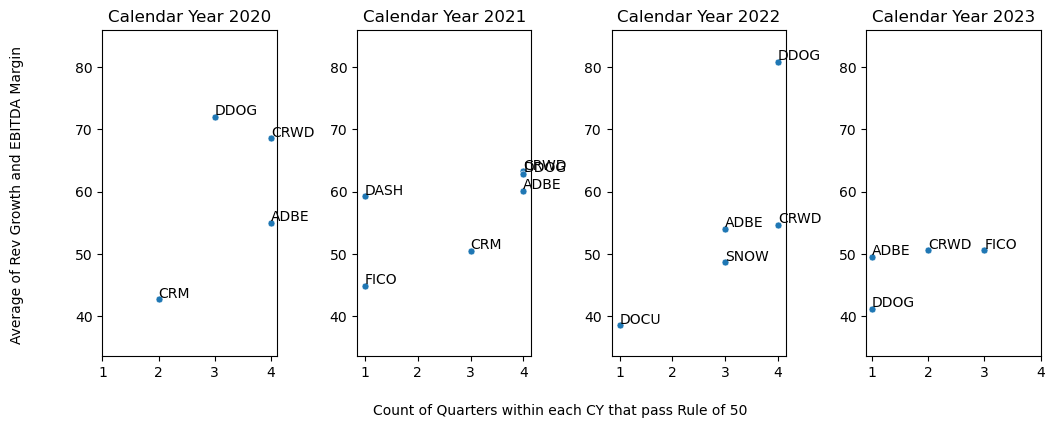

In [23]:
# Filter the data for each year and create scatter plots
years = [2020, 2021, 2022, 2023]
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

# Define the common ylim based on the range of data across all years
common_ylim = (rule50_pass['Average of Rev Growth and EBITDA Margin within CY'].min() - 5,
               rule50_pass['Average of Rev Growth and EBITDA Margin within CY'].max() + 5)

for i, year in enumerate(years):
    data_year = rule50_pass[rule50_pass['Calendar Year'] == year]
    ax = axes[i]
    
    sns.scatterplot(x='Rule50_Pass', y='Average of Rev Growth and EBITDA Margin within CY', data=data_year, s=25, ax=ax)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    ax.set_title(f'Calendar Year {year}')
    ax.set_xticks([1, 2, 3, 4])
    
    # Set common ylim for all subplots
    ax.set_ylim(common_ylim)

    for j, row in data_year.iterrows():
        ax.text(x=row['Rule50_Pass'], 
                y=row['Average of Rev Growth and EBITDA Margin within CY'] + 2, 
                s=row['Ticker'], va='top')

# Set x-axis and y-axis labels for the entire frame
fig.text(0.5, -0.05, 'Count of Quarters within each CY that pass Rule of 50', ha='center')
fig.text(-0.05, 0.5, 'Average of Rev Growth and EBITDA Margin', va='center', rotation='vertical')
        
# Adjust layout
plt.tight_layout()
plt.show()

#### Q4: Which stocks achieve Rule of 40 in at least 2 quarters in each of the last 4 years: 2020 - 2023?

In [24]:
# Group the data by 'Ticker' and 'Calendar Year' and count the number of quarters meeting Rule 40
rule40_counts = focused_df.groupby(['Ticker', 'Calendar Year'])['Rule40_Pass'].sum().reset_index()

# Calculate the average 'YoY Rev Growth + EBITDA Margin' for each Ticker and Year
average_yoy_margin = focused_df.groupby(['Ticker', 'Calendar Year'])['YoY Rev Growth + EBITDA Margin'].mean().reset_index()

# Merge the 'rule40_counts' DataFrame with the calculated averages
rule40_counts = rule40_counts.merge(average_yoy_margin, on=['Ticker', 'Calendar Year'], how='left')

# Rename the new column to indicate it's the average
rule40_counts.rename(columns={'YoY Rev Growth + EBITDA Margin': 'Average of Rev Growth and EBITDA Margin within CY'}, inplace=True)

# Filter stocks where each year has at least 2 quarters meeting Rule 40
rule40_pass = rule40_counts[rule40_counts['Rule40_Pass'] >= 2]

display(rule40_pass)

,Ticker,Calendar Year,Rule40_Pass,Average of Rev Growth and EBITDA Margin within CY
0,ADBE,2020,4,55
1,ADBE,2021,4,60
2,ADBE,2022,4,54
3,ADBE,2023,4,50
16,CRM,2020,3,43
17,CRM,2021,4,51
18,CRM,2022,2,37
20,CRWD,2020,4,69
21,CRWD,2021,4,63
22,CRWD,2022,4,55


**Observations**
* Of the 15 stocks we are analyzing, 7 stocks achieve Rule of 40 in at least 2 quarters of each year listed above.
    - ADBE and CRWD are the leaders with 4 years all achieving Rule of 40 in all 4 quarters
    - CRM and DDOG passed Rule of 40 in 3 years 2020-2022 but failed in 2023
    - DOCU passed Rule of 40 in 2 years 2021-2022 but failed in 2023
    - FICO passed Rule of 40 in year 2021 and 2023
    - SNOW passed Rule of 40 in 2022

**Let's visualize this table**

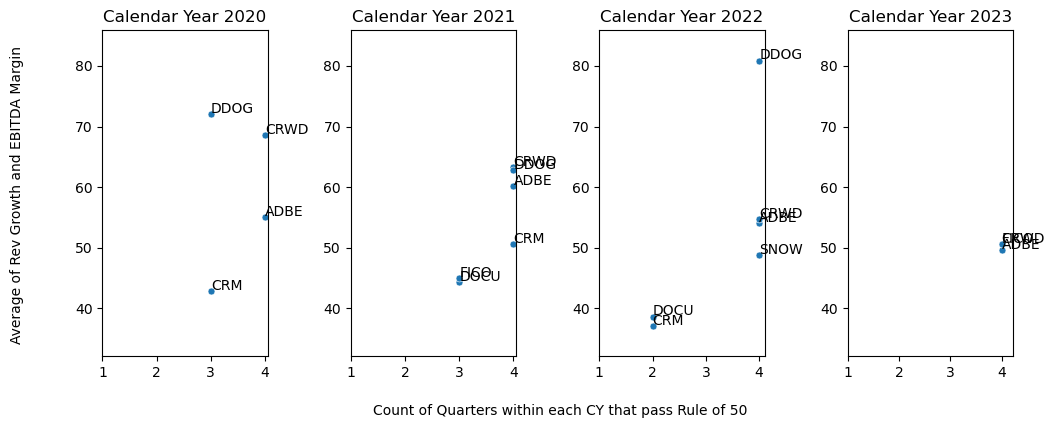

In [25]:
# Filter the data for each year and create scatter plots
years = [2020, 2021, 2022, 2023]
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

# Define the common ylim based on the range of data across all years
common_ylim = (rule40_pass['Average of Rev Growth and EBITDA Margin within CY'].min() - 5,
               rule40_pass['Average of Rev Growth and EBITDA Margin within CY'].max() + 5)

for i, year in enumerate(years):
    data_year = rule40_pass[rule40_pass['Calendar Year'] == year]
    ax = axes[i]
    
    sns.scatterplot(x='Rule40_Pass', y='Average of Rev Growth and EBITDA Margin within CY', data=data_year, s=25, ax=ax)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    ax.set_title(f'Calendar Year {year}')
    ax.set_xticks([1, 2, 3, 4])
    
    # Set common ylim for all subplots
    ax.set_ylim(common_ylim)

    for j, row in data_year.iterrows():
        ax.text(x=row['Rule40_Pass'], 
                y=row['Average of Rev Growth and EBITDA Margin within CY'] + 2, 
                s=row['Ticker'], va='top')

# Set x-axis and y-axis labels for the entire frame
fig.text(0.5, -0.05, 'Count of Quarters within each CY that pass Rule of 50', ha='center')
fig.text(-0.05, 0.5, 'Average of Rev Growth and EBITDA Margin', va='center', rotation='vertical')
        
# Adjust layout
plt.tight_layout()
plt.show()

**Let's zoom into each stock to see what drives their addition or removal from High-Performance Clubs**

##### 1. Dive into the story of ADBE: Rely on strong and consistent EBITDA Margin while Revenue Growth slows down

In [26]:
# Take a look at ADBE
focused_ADBE = focused_df[focused_df['Ticker'] == 'ADBE']
focused_ADBE

,Ticker,fiscalDateEnding,Calendar Year,Calendar Quarter,Last 4Q Revenue (mil),Last 4Q EBITDA (mil),YoY Rolling 4Q Revenue Growth,Rolling 4Q EBITDA Margin %,YoY Rev Growth + EBITDA Margin,Rule40_Pass,Rule50_Pass
15,ADBE,2020-02-28,2020,1,"11,661","4,139",22,35,58,True,True
14,ADBE,2020-05-29,2020,2,"12,045","4,410",19,37,56,True,True
13,ADBE,2020-08-28,2020,3,"12,436","4,613",17,37,54,True,True
12,ADBE,2020-11-27,2020,4,"12,868","4,850",15,38,53,True,True
11,ADBE,2021-03-05,2021,1,"13,682","5,355",17,39,56,True,True
10,ADBE,2021-06-04,2021,2,"14,389","5,737",19,40,59,True,True
9,ADBE,2021-09-03,2021,3,"15,099","6,085",21,40,62,True,True
8,ADBE,2021-12-03,2021,4,"15,785","6,378",23,40,63,True,True
7,ADBE,2022-03-04,2022,1,"16,142","6,497",18,40,58,True,True
6,ADBE,2022-06-03,2022,2,"16,693","6,616",16,40,56,True,True


**Observation:**

* ADBE not only passes Rule of 40 (applied to rolling 4Qs Revenue & EBITDA) in all quarters of 4 years but also achieves Rule of 50 in all quarters and years (Q2-Q3 of 2023 is a bit above 49% but could be considered 50% for all intents and purposes)

* Since 2020, ADBE YoY Revenue growth has slowed down from 20% to 10%, but due to consistently strong EBITDA performance in the 40% range, ADBE consistently passes Rule of 40 and Rule of 50. In other words, strong EBITDA Margin accounts for 70%-80% of ADBE's success in achiving Rule of 50 Accolate

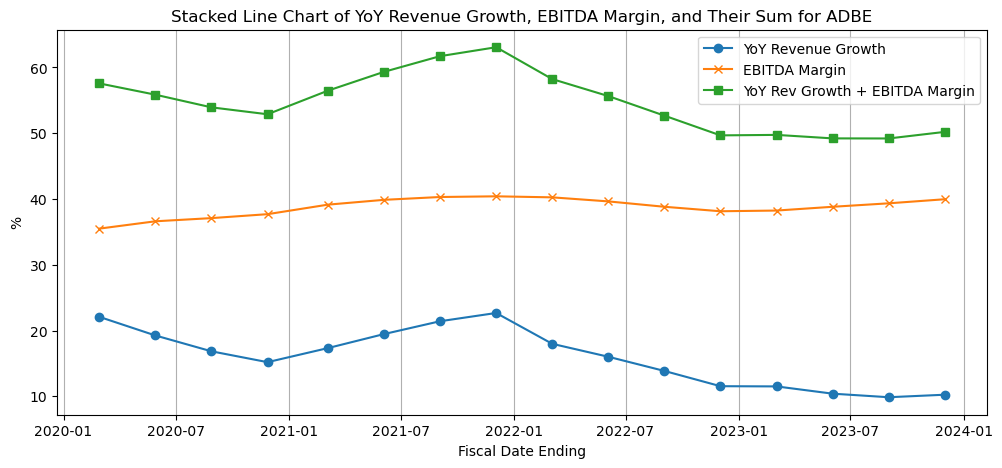

In [36]:
# Create a stacked line chart
plt.figure(figsize=(12, 5))

# Plot 'YoY Rolling 4Q Revenue Growth' as a line
plt.plot(focused_ADBE['fiscalDateEnding'], focused_ADBE['YoY Rolling 4Q Revenue Growth'], label='YoY Revenue Growth', marker='o')

# Plot 'Rolling 4Q EBITDA Margin %' as a line on the same axes
plt.plot(focused_ADBE['fiscalDateEnding'], focused_ADBE['Rolling 4Q EBITDA Margin %'], label='EBITDA Margin', marker='x')

# Plot the sum as a line on the same axes (stacked)
plt.plot(focused_ADBE['fiscalDateEnding'], focused_ADBE['YoY Rev Growth + EBITDA Margin'], label='YoY Rev Growth + EBITDA Margin', marker='s')

# Set labels and title
plt.xlabel('Fiscal Date Ending')
plt.ylabel('%')
plt.title('Chart of YoY Revenue Growth, EBITDA Margin, and Their Sum for ADBE')

# Add legend
plt.legend()
plt.grid(axis='x')

# Show the plot
plt.show()

##### 2. Dive into the story of FICO: Rely exclusively on EBITDA Margin while Revenue Growth dips negative (shortly)

In [28]:
# Take a look at FICO
focused_FICO = focused_df[focused_df['Ticker'] == 'FICO']
focused_FICO

,Ticker,fiscalDateEnding,Calendar Year,Calendar Quarter,Last 4Q Revenue (mil),Last 4Q EBITDA (mil),YoY Rolling 4Q Revenue Growth,Rolling 4Q EBITDA Margin %,YoY Rev Growth + EBITDA Margin,Rule40_Pass,Rule50_Pass
15,FICO,2020-03-31,2020,1,"1,226",310,17,25,42,True,False
14,FICO,2020-06-30,2020,2,"1,226",310,10,25,36,False,False
13,FICO,2020-09-30,2020,3,"1,295",323,12,25,37,False,False
12,FICO,2020-12-31,2020,4,"1,306",367,9,28,37,False,False
11,FICO,2021-03-31,2021,1,"1,320",394,8,30,38,False,False
10,FICO,2021-06-30,2021,2,"1,427",503,16,35,52,True,True
9,FICO,2021-09-30,2021,3,"1,376",534,6,39,45,True,False
8,FICO,2021-12-31,2021,4,"1,376",553,5,40,46,True,False
7,FICO,2022-03-31,2022,1,"1,395",600,6,43,49,True,False
6,FICO,2022-06-30,2022,2,"1,304",542,-9,42,33,False,False


**Observations:**
- FICO had EBITDA Margin consistently improved from 25% in 2020 to 46% in 2023
- This strong margin improvement helps FICO achieve Rule of 40 in 2021 and Q1 2023 even though revenue growth significantly slowed down overtime to low single digit, and even dipped to (-4%) in Q1 2023

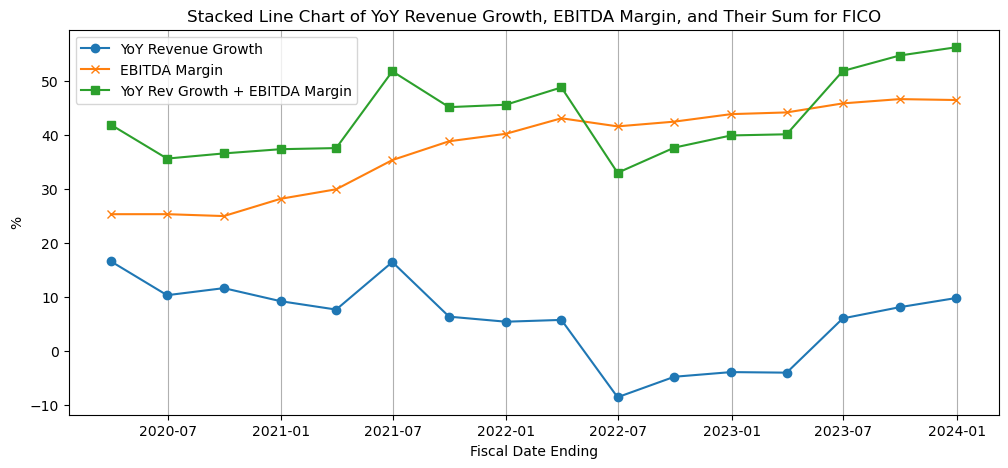

In [37]:
# Create a stacked line chart
plt.figure(figsize=(12, 5))

# Plot 'YoY Rolling 4Q Revenue Growth' as a line
plt.plot(focused_FICO['fiscalDateEnding'], focused_FICO['YoY Rolling 4Q Revenue Growth'], label='YoY Revenue Growth', marker='o')

# Plot 'Rolling 4Q EBITDA Margin %' as a line on the same axes
plt.plot(focused_FICO['fiscalDateEnding'], focused_FICO['Rolling 4Q EBITDA Margin %'], label='EBITDA Margin', marker='x')

# Plot the sum as a line on the same axes (stacked)
plt.plot(focused_FICO['fiscalDateEnding'], focused_FICO['YoY Rev Growth + EBITDA Margin'], label='YoY Rev Growth + EBITDA Margin', marker='s')

# Set labels and title
plt.xlabel('Fiscal Date Ending')
plt.ylabel('%')
plt.title('Chart of YoY Revenue Growth, EBITDA Margin, and Their Sum for FICO')

# Add legend
plt.legend()
plt.grid(axis='x')

# Show the plot
plt.show()

##### 3. Dive into the story of CRM: Rely half - half on Revenue Growth and EBITDA Margin

In [30]:
# Take a look at CRM
focused_CRM = focused_df[focused_df['Ticker'] == 'CRM']
focused_CRM

,Ticker,fiscalDateEnding,Calendar Year,Calendar Quarter,Last 4Q Revenue (mil),Last 4Q EBITDA (mil),YoY Rolling 4Q Revenue Growth,Rolling 4Q EBITDA Margin %,YoY Rev Growth + EBITDA Margin,Rule40_Pass,Rule50_Pass
15,CRM,2020-01-31,2020,1,"17,469","2,971",6,17,23,False,False
14,CRM,2020-04-30,2020,2,"18,704","2,747",31,15,45,True,False
13,CRM,2020-07-31,2020,3,"19,969","3,605",34,18,52,True,True
12,CRM,2020-10-31,2020,4,"20,756","4,847",28,23,51,True,True
11,CRM,2021-01-31,2021,1,"22,027","5,532",26,25,51,True,True
10,CRM,2021-04-30,2021,2,"23,197","6,124",24,26,50,True,True
9,CRM,2021-07-31,2021,3,"24,988","6,196",25,25,50,True,False
8,CRM,2021-10-31,2021,4,"26,979","5,585",30,21,51,True,True
7,CRM,2022-01-31,2022,1,"28,129","5,051",28,18,46,True,False
6,CRM,2022-04-30,2022,2,"29,252","4,655",26,16,42,True,False


**Observations:**

* CRM passed Rule of 40 between Q2 2020 and Q2 2022, and especially passed Rule of 50 between Q3 2020 and 2021, with Revenue growth and EBITDA each contributing roughly half and half to its impressive performance

* From Q3 2022, YoY revenue growth started to decelarate from 20% to 10%. That combined with EBITDA margin declined from 20%+ range in pre-2022 period to 15% moving into 2023 caused CRM to fail Rule of 40. 

* With layoff decision to cut cost in 2023, EBITDA margin improved to 23% in the LTM leading to Oct 2023, yet with YoY growth at 10%, CRM still fails Rule of 40

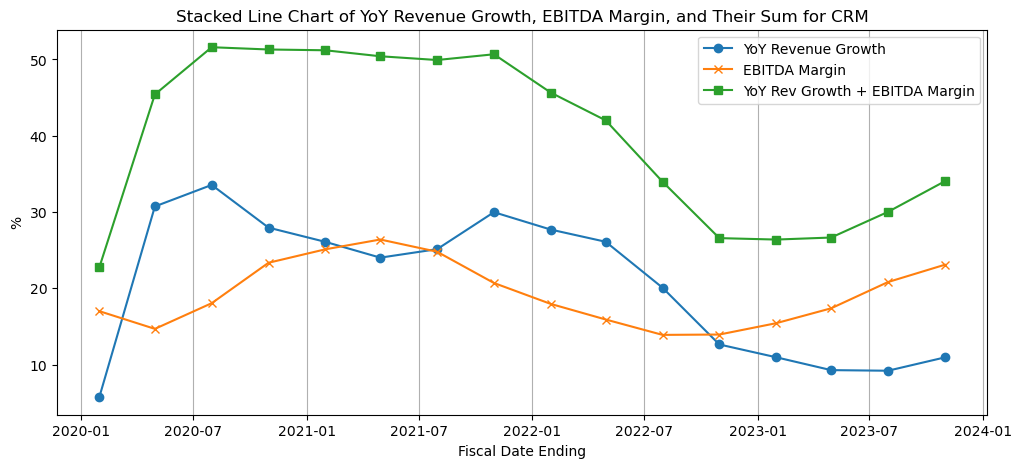

In [39]:
# Create a stacked line chart
plt.figure(figsize=(12, 5))

# Plot 'YoY Rolling 4Q Revenue Growth' as a line
plt.plot(focused_CRM['fiscalDateEnding'], focused_CRM['YoY Rolling 4Q Revenue Growth'], label='YoY Revenue Growth', marker='o')

# Plot 'Rolling 4Q EBITDA Margin %' as a line on the same axes
plt.plot(focused_CRM['fiscalDateEnding'], focused_CRM['Rolling 4Q EBITDA Margin %'], label='EBITDA Margin', marker='x')

# Plot the sum as a line on the same axes (stacked)
plt.plot(focused_CRM['fiscalDateEnding'], focused_CRM['YoY Rev Growth + EBITDA Margin'], label='YoY Rev Growth + EBITDA Margin', marker='s')

# Set labels and title
plt.xlabel('Fiscal Date Ending')
plt.ylabel('%')
plt.title('Chart of YoY Revenue Growth, EBITDA Margin, and Their Sum for CRM')

# Add legend
plt.legend()
plt.grid(axis='x')

# Show the plot
plt.show()

##### 4. Dive into the story of DDOG: Rely exlusively on Revenue Growth with essentially zero EBITDA Margin

In [32]:
# Take a look at DDOG
focused_DDOG = focused_df[focused_df['Ticker'] == 'DDOG']
focused_DDOG

,Ticker,fiscalDateEnding,Calendar Year,Calendar Quarter,Last 4Q Revenue (mil),Last 4Q EBITDA (mil),YoY Rolling 4Q Revenue Growth,Rolling 4Q EBITDA Margin %,YoY Rev Growth + EBITDA Margin,Rule40_Pass,Rule50_Pass
14,DDOG,2020-03-31,2020,1,420,11,NaN,3,NaN,False,False
13,DDOG,2020-06-30,2020,2,473,21,78,4,82,True,True
12,DDOG,2020-09-30,2020,3,519,23,67,4,71,True,True
11,DDOG,2020-12-31,2020,4,573,24,59,4,63,True,True
10,DDOG,2021-03-31,2021,1,637,10,51,2,53,True,True
9,DDOG,2021-06-30,2021,2,729,2,54,0,55,True,True
8,DDOG,2021-09-30,2021,3,853,6,64,1,65,True,True
7,DDOG,2021-12-31,2021,4,"1,009",26,76,3,79,True,True
6,DDOG,2022-03-31,2022,1,"1,173",52,84,4,89,True,True
5,DDOG,2022-06-30,2022,2,"1,346",64,85,5,89,True,True


**Observations:**

* DDOG achieves both Rule of 40 and Rule of 50 from 2020 to Q1 2023, almost exclusively due to hyper YoY revenue growth, while EBITDA Margin hovers in the low single digit rate

* In Q2 and Q3 of 2023, LTM revenue growth slows down from 50%+ to 40% and then 32%, while LTM EBITDA Marign slightly dips to negative territory, pushing DDOG out of "Rule of 40" and "Rule of 50" fancy clubs

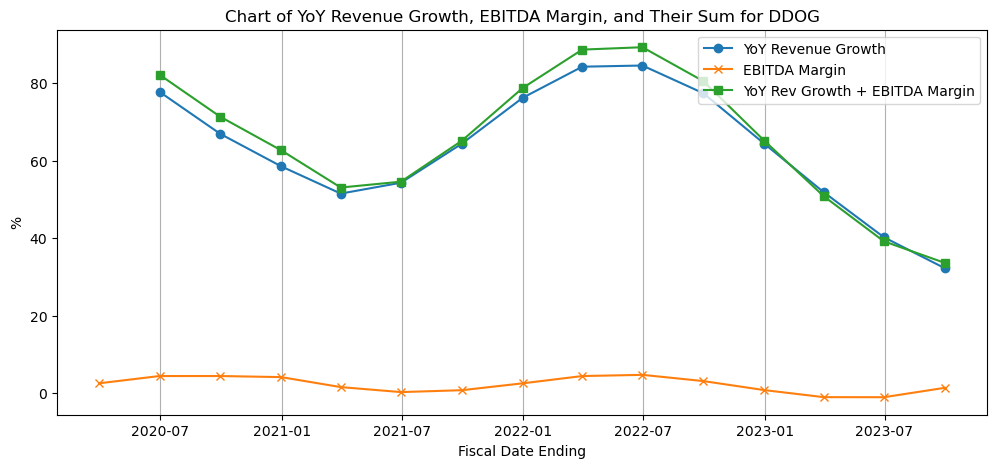

In [40]:
# Create a stacked line chart
plt.figure(figsize=(12, 5))

# Plot 'YoY Rolling 4Q Revenue Growth' as a line
plt.plot(focused_DDOG['fiscalDateEnding'], focused_DDOG['YoY Rolling 4Q Revenue Growth'], label='YoY Revenue Growth', marker='o')

# Plot 'Rolling 4Q EBITDA Margin %' as a line on the same axes
plt.plot(focused_DDOG['fiscalDateEnding'], focused_DDOG['Rolling 4Q EBITDA Margin %'], label='EBITDA Margin', marker='x')

# Plot the sum as a line on the same axes (stacked)
plt.plot(focused_DDOG['fiscalDateEnding'], focused_DDOG['YoY Rev Growth + EBITDA Margin'], label='YoY Rev Growth + EBITDA Margin', marker='s')

# Set labels and title
plt.xlabel('Fiscal Date Ending')
plt.ylabel('%')
plt.title('Chart of YoY Revenue Growth, EBITDA Margin, and Their Sum for DDOG')

# Add legend outside of chart
plt.legend(loc='upper right')

# Remove x-axis grid
plt.grid(axis='x')

# Show the plot
plt.show()

##### 5. Dive into the story of SNOW: Rely exclusively on Revenue Growth with negative EBITDA Margin

In [34]:
# Take a look at SNOW
focused_SNOW = focused_df[focused_df['Ticker'] == 'SNOW']
focused_SNOW

,Ticker,fiscalDateEnding,Calendar Year,Calendar Quarter,Last 4Q Revenue (mil),Last 4Q EBITDA (mil),YoY Rolling 4Q Revenue Growth,Rolling 4Q EBITDA Margin %,YoY Rev Growth + EBITDA Margin,Rule40_Pass,Rule50_Pass
15,SNOW,2020-01-31,2020,1,NaN,NaN,NaN,NaN,NaN,False,False
14,SNOW,2020-04-30,2020,2,NaN,NaN,NaN,NaN,NaN,False,False
13,SNOW,2020-07-31,2020,3,403,-343,NaN,-85,NaN,False,False
12,SNOW,2020-10-31,2020,4,492,-423,NaN,-86,NaN,False,False
11,SNOW,2021-01-31,2021,1,598,-538,NaN,-90,NaN,False,False
10,SNOW,2021-04-30,2021,2,722,-639,NaN,-89,NaN,False,False
9,SNOW,2021-07-31,2021,3,864,-762,115,-88,26,False,False
8,SNOW,2021-10-31,2021,4,"1,039",-749,111,-72,39,False,False
7,SNOW,2022-01-31,2022,1,"1,232",-688,106,-56,50,True,True
6,SNOW,2022-04-30,2022,2,"1,426",-663,98,-46,51,True,True


**Observations:**

* SNOW becomes IPO in Sep 2020 so Last Twelve Month or Trailing 4 Quarters data is not available unitl Q3 2021. Since its IPO, YoY Revenue Growth rate has been in the "super growth" club (>=50% YoY), although growth has consitently normalized/slowed down as the denominator grows larger each day. YoY Revenue growth for Trailing 4Qs ending in Oct 2023 of 41% is the lowest number since IPO, YET still an impressive number and a dream for many SaaS firms

* Due to its growth mode, EBITDA margin is still in the negative territory by a significant amount, albeit an improvement in 2023 compared to 2020

* SNOW passes Rule of 40 for all quarters of 2022 and passed Rule of 50 for the first 3 quarters of 2022 due to 90% YoY Revenue Growth balancing out with 40% EBITDA Margin

* Marching into 2023, YoY Revenue growth slows down much faster than previous periods while EBITDA stops at around -37%, meaning that the improvement in EBITDA Margin is too small to offset the fast decline in YoY Revenue growth

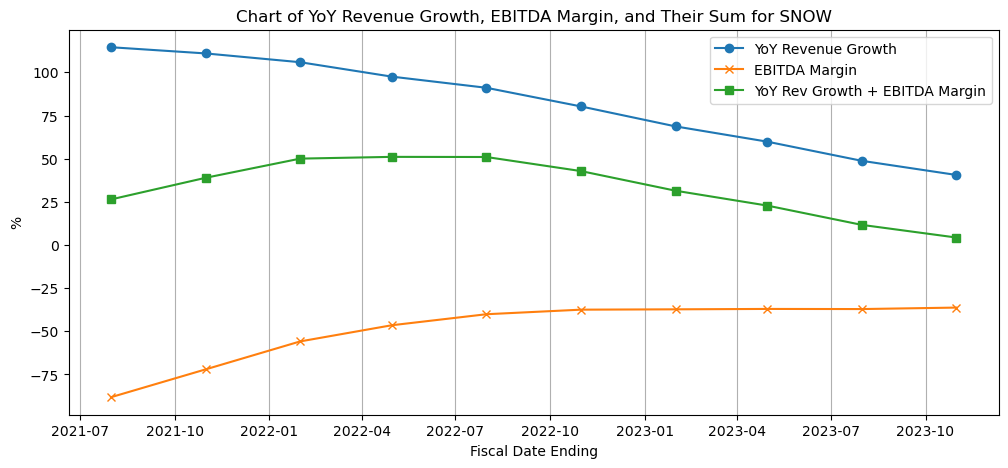

In [41]:
# Filter data for dates after September 2021
filtered_data = focused_SNOW[focused_SNOW['fiscalDateEnding'] >= '2021-07-01']

# Create a stacked line chart
plt.figure(figsize=(12, 5))

# Plot 'YoY Rolling 4Q Revenue Growth' as a line
plt.plot(filtered_data['fiscalDateEnding'], filtered_data['YoY Rolling 4Q Revenue Growth'], label='YoY Revenue Growth', marker='o')

# Plot 'Rolling 4Q EBITDA Margin %' as a line on the same axes
plt.plot(filtered_data['fiscalDateEnding'], filtered_data['Rolling 4Q EBITDA Margin %'], label='EBITDA Margin', marker='x')

# Plot the sum as a line on the same axes (stacked)
plt.plot(filtered_data['fiscalDateEnding'], filtered_data['YoY Rev Growth + EBITDA Margin'], label='YoY Rev Growth + EBITDA Margin', marker='s')

# Set labels and title
plt.xlabel('Fiscal Date Ending')
plt.ylabel('%')
plt.title('Chart of YoY Revenue Growth, EBITDA Margin, and Their Sum for SNOW')

# Add legend
plt.legend()
plt.grid(axis='x')

# Show the plot
plt.show()

**Observation: As we can see, there are 3 main ways to achieve Rule of 40/50, depending on stages of companies**